In [1]:
import cv2
import numpy as np
from scipy import ndimage, misc
from matplotlib import pyplot as plt

In [2]:
def find_limits(img, lb, ub):
    w, h = img.shape
    im_arr = np.reshape(img, (w*h))
    
    im_arr = np.sort(im_arr)
    
    i_a = int(round(w*h * lb, 0))
    i_b = int(round(w*h * ub, 0))
    
    a = im_arr[i_a-1]
    b = im_arr[i_b-1]
    
    t = find_t(im_arr, i_a, i_b)
    
    return a, b, t

def find_t(arr, ia, ib):
    a, b = arr[ia], arr[ib]
    
    interval = arr[ia:ib+1]
    mean_i = sum(interval) / len(interval)
    
    t = (2*mean_i*(b - a)) / (255*(a+b))
    
    return t

def nl_grayscale(img, lb, ub):
    '''
    Non-linear grayscale transformation
    '''
    new_a = 0
    new_b = 255
    a, b, t = find_limits(img, lb, ub)
    w, h = img.shape
    

    im_out = img.copy()
    
    i = img<a
    im_out[i] = new_a
    
    i = img > b
    im_out[i] = new_b
    
    
    for i in range(w):
        for j in range(h):
            if img[i, j] < a and not img[i, j] > b:
                new_a + ((new_a - new_b) / (a**t - b**t)) * (img[i, j]**t - a**t)
                
                
    #im_out[not img<b] = new_b
    #im_out[img<a and not img<b] = new_a
    
    return im_out

In [3]:
def improved_otsu(img, thresh, ksize=7):
    '''
    Improved Otsu's Method
    '''

    w, h = img.shape
    x = ksize // 2
    y = ksize // 2
    im_out = img.copy()
    
    # STEP 1 -> 3
    
    while not x > w:
        while y < (h - ksize // 2):
            
            if not x == w:
                window = img[(x-3):(x+4),(y-3):(y+4)]
            else:
                window = img[(x-3):x,(y-3):(y+4)]
                
            var = window.std()
            

            if var < thresh:
                new_thresh, seg_window = cv2.threshold(window, thresh, 255, cv2.THRESH_BINARY_INV)
            else:
                new_thresh, seg_window = cv2.threshold(window, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                
                
            if not x == w:
                im_out[(x-3):(x+4),(y-3):(y+4)] = seg_window
            else:
                im_out[(x-3):x,(y-3):(y+4)] = seg_window
                
            y += ksize
            
            #m = window.mean()
            #var = sum([(i - m) ** 2 for i in window]) / ksize**2
            #var = sum([sum([ (i[j] - m) ** 2 for j in range(7)]) for i in window])/ 7 ** 2
            
            #print(var)
            #print((x-3), (x+4), y-3, y+4)
        
        if not x == w:
            window = img[(x-3):(x+4),(y-3):y]
        else:
            window = img[(x-3):x,(y-3):y]
            
        var = window.std()
        
        if var < thresh:
            new_thresh, seg_window = cv2.threshold(window, thresh, 255, cv2.THRESH_BINARY_INV)
        else:
            new_thresh, seg_window = cv2.threshold(window, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        if not x == w:
            im_out[(x-3):(x+4),(y-3):y] = seg_window
        else:
            im_out[(x-3):x,(y-3):y] = seg_window
            
        x += ksize
        y = ksize // 2
    
    window = img[(x-3):x,(y-3):(y+4)]
    var = window.std()
    if var < thresh:
        new_thresh, seg_window = cv2.threshold(window, thresh, 255, cv2.THRESH_BINARY_INV)
    else:
        new_thresh, seg_window = cv2.threshold(window, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    im_out[(x-3):x,(y-3):(y+4)] = seg_window

    return im_out

In [4]:
def crack_extraction(img):
    
    # Applies median blur
    blur = cv2.medianBlur(img, 3)

    # In order to calculate dynamic upper-bound for nl-greyscale, smoothed image is thresholded based on otsu's,
    # and opened with a 3x3 kernel (sphere). Upper bound is the fraction of the "crack region" 
    val, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    open_ = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
    upper_bound = round(np.count_nonzero(open_)/(227*227), 4)

    # Non-Linear greyscale conversion
    nl = nl_grayscale(blur, 0.02, upper_bound+0.05)

    # Improved Otsu's
    nl_val, nl_th = cv2.threshold(nl, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    imp_otsu = improved_otsu(nl, nl_val-20)
    
    return imp_otsu

In [5]:
pos = cv2.imread("C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Positive\\{0:05d}.jpg".format(np.random.randint(1,10000)))
g_pos = cv2.cvtColor(pos, cv2.COLOR_BGR2GRAY)
neg = cv2.imread("C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Negative\\{0:05d}.jpg".format(np.random.randint(1,20000)))
g_neg = cv2.cvtColor(neg, cv2.COLOR_BGR2GRAY)


cd_pos = crack_extraction(g_pos)
cd_neg = crack_extraction(g_neg)

cv2.imshow("Positive", pos)
cv2.imshow("Negative", neg)

cv2.imshow("Positive CD", cd_pos)
cv2.imshow("Negative CD", cd_neg)

cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\Rasmus\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Rasmus\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Rasmus\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars


In [22]:
pos = cv2.imread("C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Positive\\{0:05d}.jpg".format(np.random.randint(1,10000)))
g_pos = cv2.cvtColor(pos, cv2.COLOR_BGR2GRAY)
neg = cv2.imread("C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Negative\\{0:05d}.jpg".format(np.random.randint(1,20000)))
g_neg = cv2.cvtColor(neg, cv2.COLOR_BGR2GRAY)


gauss_pos = cv2.GaussianBlur(g_pos, (5,5), 0)
gauss_neg = cv2.GaussianBlur(g_neg, (5,5), 0)
             
lap_pos = cv2.Laplacian(gauss_pos, cv2.CV_64F)
lap_neg = cv2.Laplacian(gauss_neg, cv2.CV_64F)

lap_p = cv2.convertScaleAbs(lap_pos)
lap_n = cv2.convertScaleAbs(lap_neg)

cd_pos = crack_extraction(g_pos)
cd_neg = crack_extraction(g_neg)

cv2.imshow("Positive", pos)
cv2.imshow("Negative", neg)

cv2.imshow("Gauss P", gauss_pos)
cv2.imshow("Gauss N", gauss_neg)

cv2.imshow("Laplacian P", lap_p)
cv2.imshow("Laplacian  N", lap_n)

cv2.imshow("Positive CD", cd_pos)
cv2.imshow("Negative CD", cd_neg)

print(np.unique(lap_p))
print(np.unique(lap_n))
cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\Rasmus\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Rasmus\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Rasmus\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 26 27 29 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 26]


In [23]:
w, h = g_pos.shape

pi_d = []
plap_vals = []

ni_d = []
nlap_vals = []

for i in range(w):
    for j in range(h):
        if cd_pos[i,j] == 255:
            pi_d.append([i, j])
            plap_vals.append(lap_p[i,j])
        if cd_neg[i,j] == 255:
            ni_d.append([i, j])
            nlap_vals.append(lap_p[i,j])
            

plap_vals = np.asarray(plap_vals)
nlap_vals = np.asarray(nlap_vals)
   
print(len(plap_vals))
print(len(nlap_vals))

print(np.unique(plap_vals))
print(np.unique(nlap_vals))

print(plap_vals.mean())
print(plap_vals.std())

print(nlap_vals.mean())
print(nlap_vals.std())


5459
1014
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 27 29 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 14 15]
3.6460890272943765
3.3821791947867066
2.3224852071005917
1.9362490775755927


C:\Users\Rasmus\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Rasmus\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Rasmus\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars


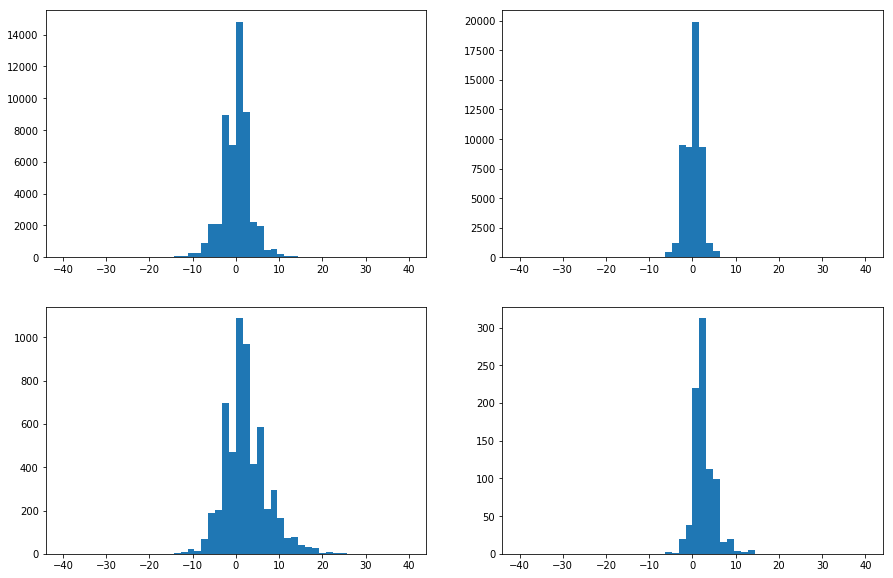

In [49]:
pos = cv2.imread("C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Positive\\{0:05d}.jpg".format(np.random.randint(1,10000)))
g_pos = cv2.cvtColor(pos, cv2.COLOR_BGR2GRAY)
neg = cv2.imread("C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Negative\\{0:05d}.jpg".format(np.random.randint(1,20000)))
g_neg = cv2.cvtColor(neg, cv2.COLOR_BGR2GRAY)

gauss_pos = cv2.GaussianBlur(g_pos, (5,5), 0)
gauss_neg = cv2.GaussianBlur(g_neg, (5,5), 0)
             
lap_pos = cv2.Laplacian(gauss_pos, cv2.CV_64F)
lap_neg = cv2.Laplacian(gauss_neg, cv2.CV_64F)

cd_pos = crack_extraction(g_pos)
cd_neg = crack_extraction(g_neg)



plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.hist(lap_pos.ravel(),50,[-40,40]);
plt.subplot(2, 2, 2)
plt.hist(lap_neg.ravel(),50,[-40,40]);
plt.subplot(2, 2, 3)
plt.hist(lap_pos[cd_pos == 255].ravel(),50,[-40,40]);
plt.subplot(2, 2, 4)
plt.hist(lap_neg[cd_neg == 255].ravel(),50,[-40,40]);

plt.show()